In [ ]:
# !pip install -q tensorflow-gpu==2.0.0-rc1
# !pip install pennylane

# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
n_epochs = 10   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 5000  # Number of train images
n_test = 1000    # Number of test images

SAVE_PATH = "drive/Shareddrives/QC/quanvolution/" # Data saving folder

# 저장한 이미지 불러오기
q_train_images = np.load(SAVE_PATH + "q_train_images.npy").tolist()
q_test_images = np.load(SAVE_PATH + "q_test_images.npy").tolist()

# 저장한 이미지의 수
print(len(q_train_images))
print(len(q_test_images))

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

5000
1000


In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data() # cifar10 데이터 불러오기

# 원본 데이터 복사
original_train_images = train_images
original_train_labels = train_labels
original_test_images = test_images
original_test_labels = test_labels

# 훈련, 테스트 데이터 개수만큼 자르기
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images.reshape((n_train, 32, 32, 3))
test_images = test_images.reshape((n_test, 32, 32, 3))

# 이미지 크기와 채널 수 구하기
image_width = train_images.shape[1]
image_height = train_images.shape[2]
image_channel = train_images.shape[3]

# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

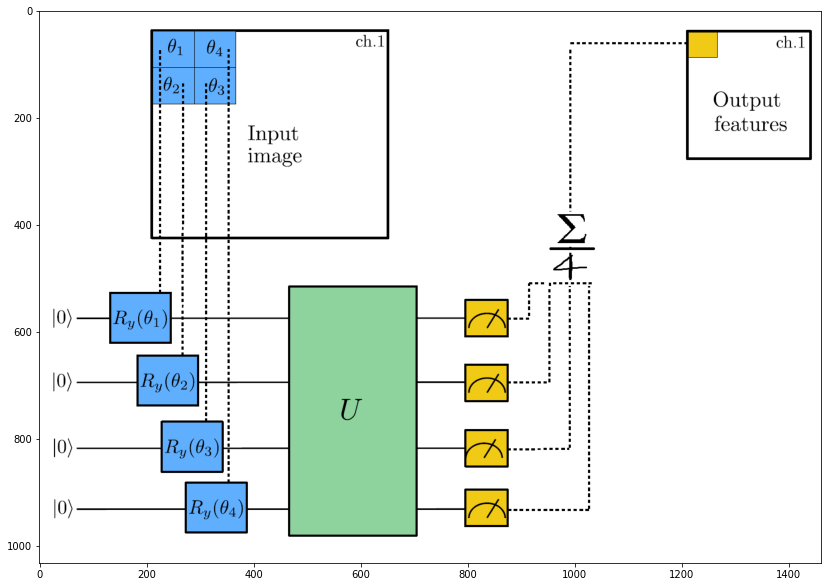

In [10]:
def quanv(image):
    filter_size = 2 # stride
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((int(image_width / filter_size), int(image_height / filter_size), image_channel))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, image_width, filter_size):
        for k in range(0, image_height, filter_size):
            for i in range(image_channel):
              phi = []
              phi.append(image[j, k, i])
              phi.append(image[j, k + 1, i])
              phi.append(image[j + 1, k, i])
              phi.append(image[j + 1, k + 1, i])
              # Process a squared 2x2 region of the image with a quantum circuit
              q_results = circuit(
                  phi=phi
              )
              # Assign sum of expectation values divided by 4 to each channels of the output pixel (j/2, k/2)
              out[j // 2, k // 2, i] = np.sum(q_results) / 4
              
    return out

layer_image = mpimg.imread(SAVE_PATH + "quanvolution_layer.png")
plt.figure(figsize=(14, 14))
plt.imshow(layer_image)

In [ ]:
# # QNN train 이미지와 QNN test 이미지를 만든다.

# # train 이미지를 만든다.
# print("Quantum pre-processing of train images:")
# for idx, img in enumerate(train_images):
#     print("{}/{}        ".format(idx + 1, n_train), end="\r") # 현재의 진행률을 표시한다.
#     q_train_images.append(quanv(img))
#     # 백번에 한번씩 저장
#     if idx % 100 == 0:
#       print(idx)
#       np.save(SAVE_PATH + "q_train_images.npy", q_train_images)

# # test 이미지를 만든다.
# print("\nQuantum pre-processing of test images:")
# for idx, img in enumerate(test_images):
#     print("{}/{}        ".format(idx + 1, n_test), end="\r") # 현재의 진행률을 표시한다.
#     q_test_images.append(quanv(img))
#     # 백번에 한번씩 저장
#     if idx % 100 == 0:
#       print(idx)
#       np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# list를 array로 변환한다.
q_train_images = np.asarray(q_train_images)
q_test_images = np.asarray(q_test_images)

print(q_train_images.shape)
print(q_test_images.shape)

(5000, 16, 16, 3)
(1000, 16, 16, 3)


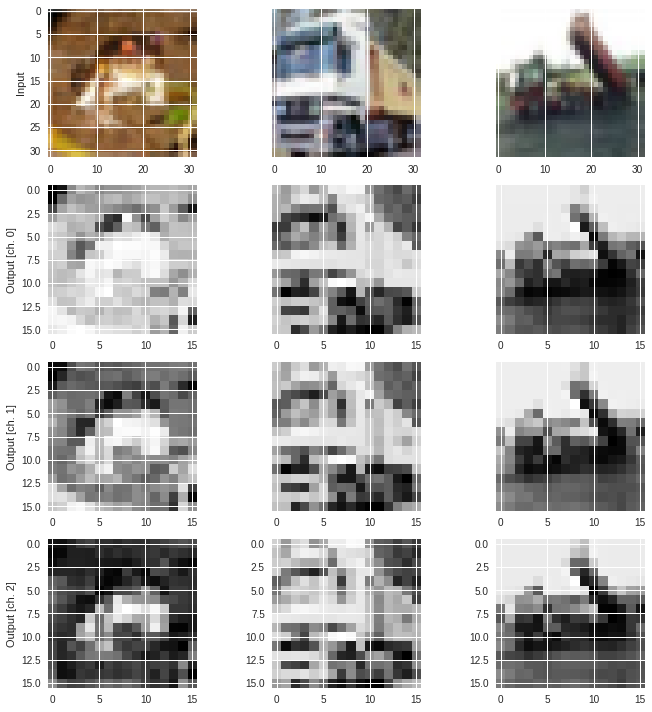

In [ ]:
# 변환된 train 이미지를 보여준다.

n_samples = 3
n_channels = 3

# 4 * 3개의 이미지를 보여줄 틀을 만든다.
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    # 원본 이미지를 보여준다.
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k])

    # 변환된 이미지를 각 채널별로 보여준다.
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c])

plt.tight_layout()
plt.show()

In [ ]:
def MyModel(is_q):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = models.Sequential()

    # QNN을 돌리기 위한 모델을 만든다. input_shape가 16 * 16 * 3이다.
    if is_q:
      # conv - max pooling - conv - fc - fc
      model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 3)))
      model.add(layers.MaxPooling2D((2, 2)))
      model.add(layers.Conv2D(64, (3, 3), activation='relu'))
      model.add(layers.Flatten())
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dense(10, activation='softmax'))
      
    # CNN 돌리기 위한 모델을 만든다. input_shape가 32 * 32 * 3이다.
    else:
      # conv - max pooling - conv - fc - fc
      model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
      model.add(layers.MaxPooling2D((2, 2)))
      model.add(layers.Conv2D(64, (3, 3), activation='relu'))
      model.add(layers.Flatten())
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dense(10, activation='softmax'))
    
    # 모델을 출력한다.
    model.summary()

    # optimizer는 adam을 사용한다.
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
# CNN 모델을 만든다.
c_model = MyModel(False)

# CNN 모델의 학습을 시작한다.
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    epochs=10
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                692288    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 712,330
Trainable params: 712,330
Non-trainable params: 0
________________________________________________

5000/5000 [==============================] - 1s 252us/sample - loss: 1.9653 - accuracy: 0.2780 - val_loss: 1.7087 - val_accuracy: 0.3870
Epoch 2/10
5000/5000 [==============================] - 1s 160us/sample - loss: 1.6010 - accuracy: 0.4346 - val_loss: 1.5455 - val_accuracy: 0.4400
Epoch 3/10
5000/5000 [==============================] - 1s 154us/sample - loss: 1.3808 - accuracy: 0.5030 - val_loss: 1.4217 - val_accuracy: 0.4960
Epoch 4/10
5000/5000 [==============================] - 1s 158us/sample - loss: 1.2394 - accuracy: 0.5672 - val_loss: 1.3759 - val_accuracy: 0.5070
Epoch 5/10
5000/5000 [==============================] - 1s 156us/sample - loss: 1.0949 - accuracy: 0.6184 - val_loss: 1.3296 - val_accuracy: 0.5400
Epoch 6/10
5000/5000 [==============================] - 1s 157us/sample - loss: 0.9809 - accuracy: 0.6576 - val_loss: 1.4169 - val_accuracy: 0.4960
Epoch 7/10
5000/5000 [==============================] - 1s 154us/sample - loss: 0.8691 - accuracy: 0.6978 - val_loss: 1.404

In [ ]:
# QNN 모델을 만든다.
q_model = MyModel(True)

# QNN 모델의 학습을 시작한다.
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    epochs=10
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 122,506
Trainable params: 122,506
Non-trainable params: 0
________________________________________________

5000/5000 [==============================] - 1s 217us/sample - loss: 1.9198 - accuracy: 0.3042 - val_loss: 2.6537 - val_accuracy: 0.1930
Epoch 2/10
5000/5000 [==============================] - 1s 126us/sample - loss: 1.5639 - accuracy: 0.4422 - val_loss: 2.9316 - val_accuracy: 0.1980
Epoch 3/10
5000/5000 [==============================] - 1s 123us/sample - loss: 1.4289 - accuracy: 0.4868 - val_loss: 2.9084 - val_accuracy: 0.2140
Epoch 4/10
5000/5000 [==============================] - 1s 123us/sample - loss: 1.3335 - accuracy: 0.5236 - val_loss: 3.0763 - val_accuracy: 0.2230
Epoch 5/10
5000/5000 [==============================] - 1s 120us/sample - loss: 1.2376 - accuracy: 0.5686 - val_loss: 3.2985 - val_accuracy: 0.2270
Epoch 6/10
5000/5000 [==============================] - 1s 123us/sample - loss: 1.1429 - accuracy: 0.5996 - val_loss: 3.4540 - val_accuracy: 0.2250
Epoch 7/10
5000/5000 [==============================] - 1s 125us/sample - loss: 1.0658 - accuracy: 0.6242 - val_loss: 3.439

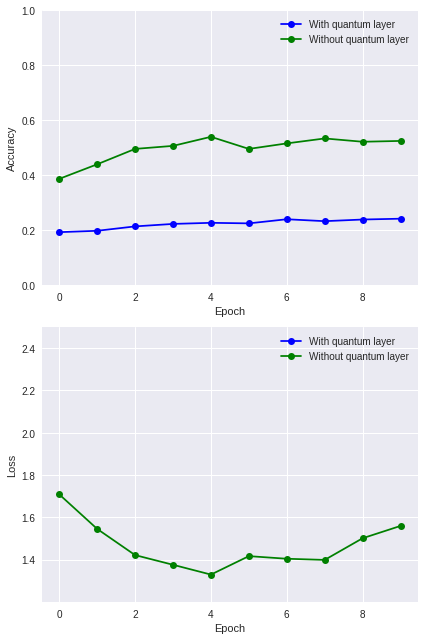

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# 정확도 그래프를 그린다.
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# 손실 그래프를 그린다.
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()